In [ ]:
!pip install -U classiq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3

In [ ]:
import classiq
classiq.authenticate()

Your user code: JDRR-SFLL
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=JDRR-SFLL


### Our task is to demonstrate quantum random walk on a straight path with 16 nodes/vertices. The 16 nodes will be in superposition as the Random walker can be on any of the 16 positions and then after the position is decided , there are 2 adjacent node either side of the current position node where the walker could move.

In [ ]:
from classiq import *
size = 4
num_nodes = 2**size

1. Coin operator: To implement such a operator , we are using Grover Diffusion Operator.
The coin operator, which calculates the probability of the walker's movement, is a quantum equivalent of tossing a coin. The walker's state is changed by the coin operator by allocating amplitudes to move left or right from each node. For example, the coin operator will set the probability to advance to node 1 if the walker is at node 0. The likelihood of the walker moving to node 14 will be set if it is at node 15. The odds for nodes in between to move left or right are spread equally.
The Grover circuit is used to amplifies the final state.


In [ ]:
@qfunc
# Prepares a qubit in the |-> state
def prepare_minus(x: QBit):
  X(x)
  H(x)

In [ ]:
@qfunc
# Implements a diffuser oracle for Grover's algorithm
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)

In [ ]:
@qfunc
# Implements the zero diffuser for the quantum walk
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

In [ ]:
# Defines the coin operation for the quantum walk
def G_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0]*num_nodes  # Initialize probability vector for 16 nodes
    if i == 0:
        prob[i + 1] = 1.0  # If at the first node, move to the right node (node 1)
    elif i == num_nodes - 1:
        prob[i - 1] = 1.0  # If at the last node, move to the left node (node 14)
    else:
        prob[i - 1] = 0.5  # Probability of moving to the left node
        prob[i + 1] = 0.5  # Probability of moving to the right node
    print(f'Node={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

In [ ]:
@qfunc
# Applies the coin operator to all vertices
def G_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      G_iteration(i,vertices,adjacent_vertices)

Swap Operator:
After determining the movement probabilities, the shift operator is applied. This operator executes the movement by swapping the walker's state between nodes according to the amplitudes set by the coin operator. If the quantum state of the walker indicates a move from node 10 to nodes 9 and 11, the shift operator adjusts the state to reflect these new positions. Importantly, quantum interference can occur during this step, where the probability amplitudes of different paths combine, enhancing or diminishing the likelihood of certain outcomes.

In [ ]:
@qfunc
# Oracle that checks if two vertices are adjacent.
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)

In [ ]:
@qfunc
# Swaps the values of two QArrays bit by bit.
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))

In [ ]:
@qfunc
# Applies the shift operator to swap vertices with their adjacent vertices.
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

In [ ]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  G_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node

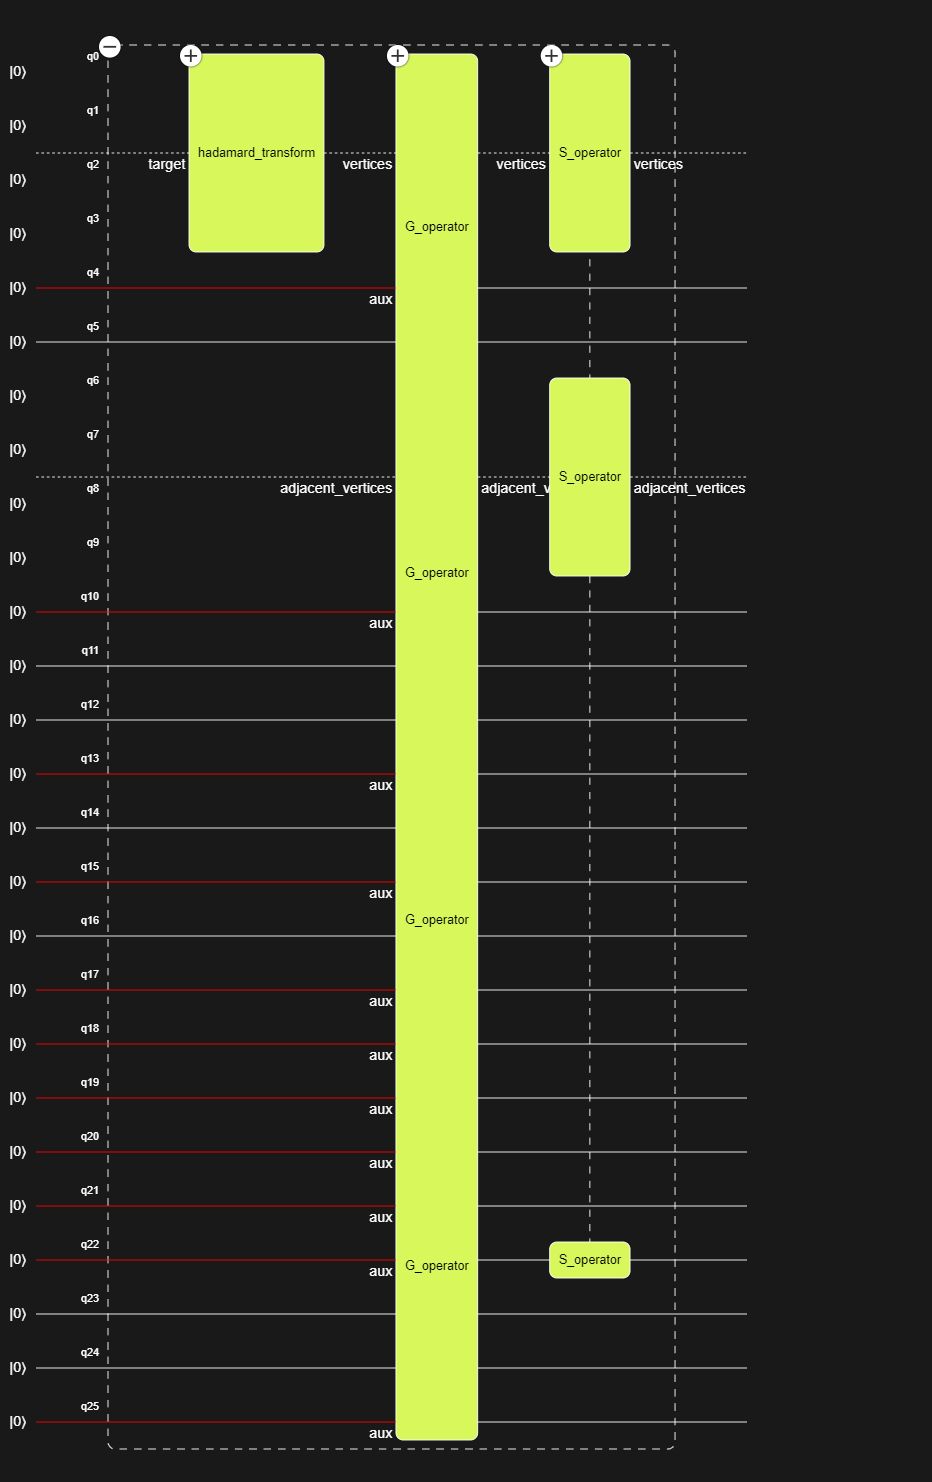